In [16]:
# I had to manually input the preprocessor into the same notebook as it was not importing from the .py file. 
import h5py
import numpy as np
from transformers import AutoTokenizer

# Load Qwen tokenizer
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load Lotka-Volterra dataset
def load_data(file_path="lotka_volterra_data.h5"):
    with h5py.File(file_path, "r") as f:
        trajectories = f["trajectories"][:]
        time_points = f["time"][:]           
    return trajectories, time_points

# LLMTIME Preprocessing Function
def preprocess_time_series(data, alpha=10, decimal_places=2):
    """
    Converts numerical time series into a text-based format compatible with Qwen's tokenizer.
    
    Parameters:
      data: input the Lotka-Volterra dataset
      alpha: scales the data by alpha
      decimal_places: Rounds to 'decimal_places'
      
    Returns:
      Formats time series using commas (,) for variables and semicolons (;) for timesteps.
    """
    # Scale and round values
    scaled_data = np.round(data / alpha, decimals=decimal_places)

    # Convert to formatted text sequence
    sequence_strings = []
    for system in scaled_data:  # Loop over each system
        formatted_timesteps = [",".join(map(str, timestep)) for timestep in system]
        sequence_strings.append(";".join(formatted_timesteps))  # Join timesteps

    return sequence_strings

# Tokenize sequence using Qwen
def tokenize_sequence(sequence):
    """
    Tokenizes the preprocessed sequence using Qwen2.5 tokenizer.
    """
    tokenized = tokenizer(sequence, return_tensors="pt")["input_ids"]
    return tokenized.tolist()[0]  # Convert tensor to list

# Example usage
if __name__ == "__main__":
    trajectories, time_points = load_data()

    # Preprocess first system
    example_sequences = preprocess_time_series(trajectories[:2])  # First two systems

    # Show preprocessed and tokenized results
    for i, seq in enumerate(example_sequences):
        print(f"Example {i+1}:")
        print("Preprocessed Sequence:", seq[:100], "...")  # Truncate for readability
        print("Tokenized Sequence:", tokenize_sequence(seq)[:20], "...")  # Show first 20 tokens
        print("-" * 50)
        
        

Example 1:
Preprocessed Sequence: 0.09,0.1;0.07,0.08;0.07,0.06;0.07,0.04;0.08,0.03;0.1,0.02;0.13,0.02;0.16,0.02;0.2,0.02;0.25,0.02;0.3 ...
Tokenized Sequence: [15, 13, 15, 24, 11, 15, 13, 16, 26, 15, 13, 15, 22, 11, 15, 13, 15, 23, 26, 15] ...
--------------------------------------------------
Example 2:
Preprocessed Sequence: 0.1,0.1;0.11,0.08;0.13,0.07;0.15,0.06;0.19,0.05;0.23,0.05;0.27,0.05;0.32,0.05;0.36,0.06;0.4,0.07;0.4 ...
Tokenized Sequence: [15, 13, 16, 11, 15, 13, 16, 26, 15, 13, 16, 16, 11, 15, 13, 15, 23, 26, 15, 13] ...
--------------------------------------------------


In [17]:

def decode_sequence(encoded_sequence, alpha=10):
    """
    Converts a tokenized text sequence back into a numerical array.
    Parameters:
      encoded_sequence: sequence to decode 
      alpha: scaling factor
      
     Splits by semicolon for timesteps.
     Splits by comma for prey & predator values.
    
    Converts back to floats and rescales using alpha.
    """
    time_series = []
    for timestep in encoded_sequence.split(";"):  # Split into timesteps
        # Ensure timestep has both prey and predator values
        values = timestep.split(",")
        if len(values) != 2:  
            print(f"Skipping invalid timestep: '{timestep}'")  # Debugging output
            continue  # Skip invalid entries
        
        try:
            prey, predator = map(float, values)  # Convert to float
            time_series.append([prey * alpha, predator * alpha])  # Rescale
        except ValueError:
            print(f"Error parsing values: {values}")  # Debugging output

    return np.array(time_series) if time_series else np.array([[0, 0]])

In [18]:
import torch
#import preprocessor
#from preprocessor import preprocess_time__series
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load Qwen2.5-Instruct model and tokenizer
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()  # Set to inference mode

# Load preprocessed and tokenized dataset (from 2a)
tokenized_sequences = [tokenize_sequence(seq) for seq in preprocess_time_series(trajectories[:10])]

# Evaluate on first sequence
input_tokens = torch.tensor([tokenized_sequences[0]])

# Generate prediction
with torch.no_grad():
    output_tokens = model.generate(input_tokens, max_length=len(input_tokens[0]) + 5)

# Decode output back to numerical sequence
forecasted_sequence = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
decoded_values = decode_sequence(forecasted_sequence, alpha=10)

print("Decoded Model Prediction:", decoded_values)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Skipping invalid timestep: '0.22'
Decoded Model Prediction: [[0.9 1. ]
 [0.7 0.8]
 [0.7 0.6]
 [0.7 0.4]
 [0.8 0.3]
 [1.  0.2]
 [1.3 0.2]
 [1.6 0.2]
 [2.  0.2]
 [2.5 0.2]
 [3.  0.2]
 [3.5 0.2]
 [3.9 0.3]
 [4.  0.5]
 [3.8 0.6]
 [3.3 0.8]
 [2.6 1. ]
 [1.9 1. ]
 [1.4 0.9]
 [1.1 0.8]
 [1.  0.6]
 [1.  0.5]
 [1.1 0.4]
 [1.3 0.3]
 [1.5 0.3]
 [1.8 0.2]
 [2.1 0.2]
 [2.5 0.3]
 [2.8 0.3]
 [3.1 0.3]
 [3.3 0.4]
 [3.3 0.5]
 [3.  0.7]
 [2.6 0.8]
 [2.2 0.8]
 [1.8 0.8]
 [1.5 0.8]
 [1.3 0.7]
 [1.3 0.6]
 [1.3 0.5]
 [1.4 0.4]
 [1.6 0.4]
 [1.8 0.3]
 [2.  0.3]
 [2.3 0.3]
 [2.5 0.3]
 [2.8 0.4]
 [2.9 0.5]
 [2.9 0.5]
 [2.7 0.6]
 [2.5 0.7]
 [2.2 0.7]
 [1.9 0.7]
 [1.7 0.7]
 [1.5 0.6]
 [1.5 0.6]
 [1.5 0.5]
 [1.5 0.4]
 [1.7 0.4]
 [1.8 0.4]
 [2.  0.4]
 [2.2 0.4]
 [2.4 0.4]
 [2.5 0.4]
 [2.6 0.5]
 [2.6 0.5]
 [2.5 0.6]
 [2.4 0.6]
 [2.2 0.7]
 [2.  0.7]
 [1.8 0.7]
 [1.7 0.6]
 [1.6 0.6]
 [1.6 0.5]
 [1.7 0.5]
 [1.8 0.4]
 [1.9 0.4]
 [2.  0.4]
 [2.2 0.4]
 [2.3 0.4]
 [2.4 0.5]
 [2.5 0.5]
 [2.5 0.5]
 [2.4 0.6]
 [2.3 0.6]
 [2.1

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from properscoring import crps_ensemble

# Get true next values from dataset
true_next_values = trajectories[0, -1, :]  # Last known time step as ground truth

# Ensure forecasted output is correctly shaped
if decoded_values.shape[0] > 1:
    predicted_next_values = decoded_values[-1]  # Extract final predicted time step
else:
    predicted_next_values = np.array([0, 0])  # Fallback if missing data

# Compute standard regression metrics
mae = mean_absolute_error(true_next_values, predicted_next_values)
rmse = mean_squared_error(true_next_values, predicted_next_values, squared=False)

# Compute CRPS
true_distribution = np.expand_dims(true_next_values, axis=0)  # Convert to (1,2) shape
pred_distribution = np.expand_dims(predicted_next_values, axis=0)  # (1,2) shape
crps = crps_ensemble(true_distribution, pred_distribution).mean()

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"CRPS: {crps:.4f}")


MAE: 0.0412
RMSE: 0.0416
CRPS: 0.0412


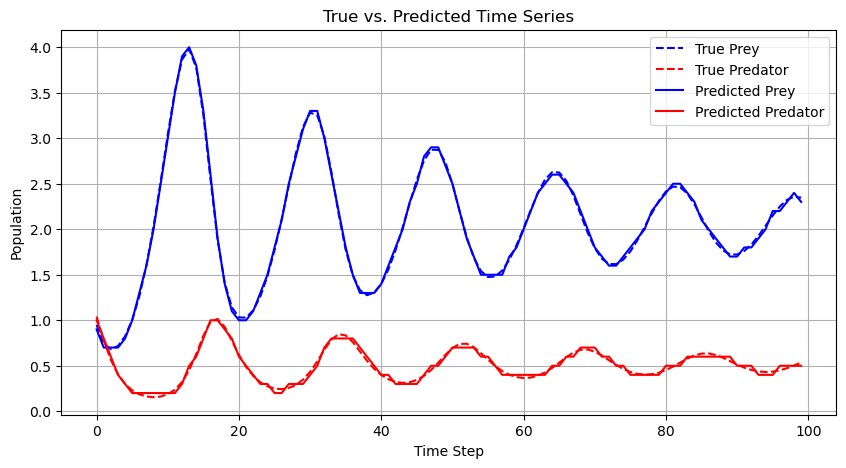

In [20]:
import matplotlib.pyplot as plt

# Get true values from dataset
true_values = trajectories[0, :, :]  # All time steps for system 0 (prey, predator)
predicted_values = decoded_values  # Model-predicted values

# Plot the true vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(true_values[:, 0], label="True Prey", color="blue", linestyle="dashed")
plt.plot(true_values[:, 1], label="True Predator", color="red", linestyle="dashed")

if predicted_values.shape[0] > 1:  # Ensure predictions exist
    plt.plot(predicted_values[:, 0], label="Predicted Prey", color="blue")
    plt.plot(predicted_values[:, 1], label="Predicted Predator", color="red")

plt.xlabel("Time Step")
plt.ylabel("Population")
plt.title("True vs. Predicted Time Series")
plt.legend()
plt.grid()
plt.savefig("True_VS_Predicted")
plt.show()


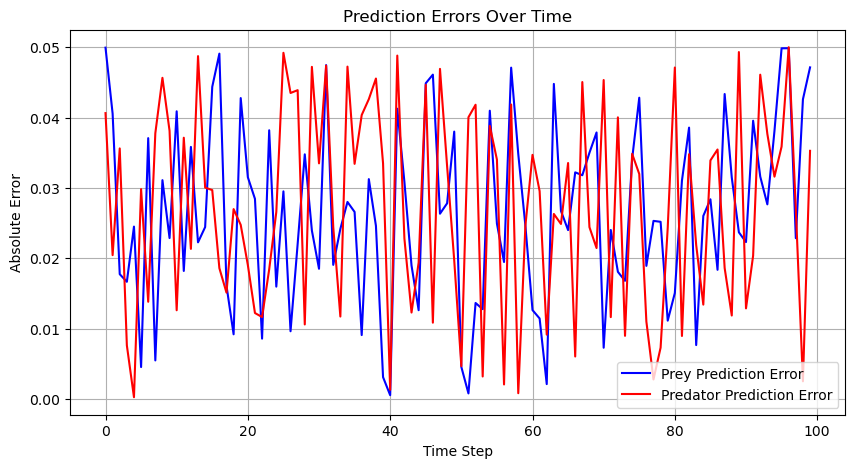

In [21]:
import numpy as np

# Compute absolute errors
errors = np.abs(true_values - predicted_values)

# Plot error for each variable
plt.figure(figsize=(10, 5))
plt.plot(errors[:, 0], label="Prey Prediction Error", color="blue")
plt.plot(errors[:, 1], label="Predator Prediction Error", color="red")

plt.xlabel("Time Step")
plt.ylabel("Absolute Error")
plt.title("Prediction Errors Over Time")
plt.legend()
plt.grid()
plt.savefig("Absolute_errors")
plt.show()


In [45]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from properscoring import crps_ensemble

# Load Qwen2.5-Instruct model and tokenizer
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()  # Set to inference mode

# Load preprocessed and tokenized dataset (from 2a)
tokenized_sequences = [tokenize_sequence(seq) for seq in preprocess_time_series(trajectories)]

# Initialize lists to store metrics
mae_list, rmse_list, crps_list = [], [], []

# Loop over all systems
for i, tokenized_seq in enumerate(tokenized_sequences):
    input_tokens = torch.tensor([tokenized_seq])

    # Generate prediction
    with torch.no_grad():
        output_tokens = model.generate(input_tokens, max_length=len(input_tokens[0]) + 5)

    # Decode output back to numerical sequence
    forecasted_sequence = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
    decoded_values = decode_sequence(forecasted_sequence, alpha=10)

    # Get true next values from dataset
    true_next_values = trajectories[i, -1, :]  # Last known time step as ground truth

    # Ensure forecasted output is correctly shaped
    if decoded_values.shape[0] > 1:
        predicted_next_values = decoded_values[-1]  # Extract final predicted time step
    else:
        predicted_next_values = np.array([0, 0])  # Fallback if missing data

    # Compute regression metrics
    mae = mean_absolute_error(true_next_values, predicted_next_values)
    rmse = mean_squared_error(true_next_values, predicted_next_values, squared=False)

    # Compute CRPS
    true_distribution = np.expand_dims(true_next_values, axis=0)  # Convert to (1,2) shape
    pred_distribution = np.expand_dims(predicted_next_values, axis=0)  # (1,2) shape
    crps = crps_ensemble(true_distribution, pred_distribution).mean()

    # Store results
    mae_list.append(mae)
    rmse_list.append(rmse)
    crps_list.append(crps)

    print(f"System {i}: MAE={mae:.4f}, RMSE={rmse:.4f}, CRPS={crps:.4f}")

# Compute overall average metrics
avg_mae = np.mean(mae_list)
avg_rmse = np.mean(rmse_list)
avg_crps = np.mean(crps_list)

print("\n--- Final Metrics Across All Systems ---")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average CRPS: {avg_crps:.4f}")


Skipping invalid timestep: '0.22'
System 0: MAE=0.0412, RMSE=0.0416, CRPS=0.0412
Skipping invalid timestep: '0.24'
System 1: MAE=0.0378, RMSE=0.0378, CRPS=0.0378
Skipping invalid timestep: '0.23'
System 2: MAE=0.0253, RMSE=0.0254, CRPS=0.0253
Skipping invalid timestep: '0.05'
System 3: MAE=0.0110, RMSE=0.0148, CRPS=0.0110
Skipping invalid timestep: '0.72'
System 4: MAE=0.0382, RMSE=0.0383, CRPS=0.0382
Skipping invalid timestep: '0.03'
System 5: MAE=0.0287, RMSE=0.0289, CRPS=0.0287
Skipping invalid timestep: '0.25'
System 6: MAE=0.0339, RMSE=0.0356, CRPS=0.0339
Skipping invalid timestep: '0.13'
System 7: MAE=0.0221, RMSE=0.0240, CRPS=0.0221
Skipping invalid timestep: '0.09'
System 8: MAE=0.0273, RMSE=0.0296, CRPS=0.0273
Skipping invalid timestep: '0.02'
System 9: MAE=0.0344, RMSE=0.0346, CRPS=0.0344
Skipping invalid timestep: '0.09'
System 10: MAE=0.0151, RMSE=0.0155, CRPS=0.0151
Error parsing values: ['0.3', '']
System 11: MAE=0.0381, RMSE=0.0382, CRPS=0.0381
Error parsing values: ['0.

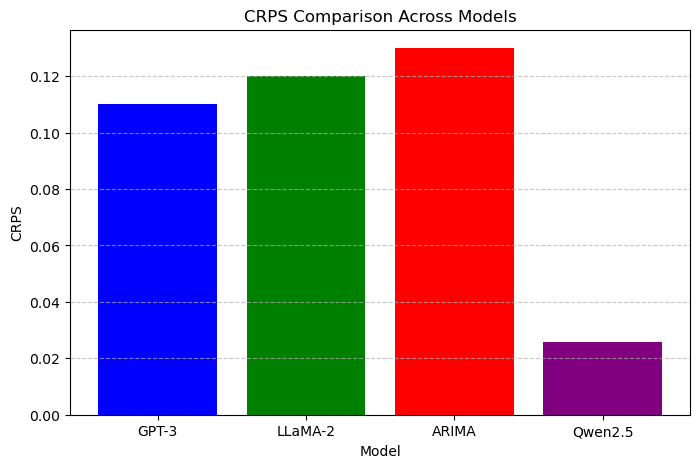

In [22]:
# A plot that should be taken lightly, compares the Qwen model performance (crps) on our data to 3 models in the paper 
# (although the settings of the paper and the data is completely different) 
plt.figure(figsize=(8, 5))
models = ["GPT-3", "LLaMA-2", "ARIMA", "Qwen2.5"]
crps_scores = [0.11, 0.12, 0.13, 0.0258]
plt.bar(models, crps_scores, color=["blue", "green", "red", "purple"])

plt.xlabel("Model")
plt.ylabel("CRPS")
plt.title("CRPS Comparison Across Models")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("crps_scores")
plt.show()


In [23]:
import numpy as np

def calculate_flops(n_layers, d_model, n_heads, d_ff, seq_len, vocab_size, training=False):
    """
    Calculate FLOPS for the forward pass of a transformer-based model like Qwen2.5-Instruct.
    Assumes FLOPS for backpropagation is 2x forward FLOPS.
    """
    
    # Embedding lookup (not counted as FLOPS, only memory lookup)
    
    # Multi-Head Attention FLOPS
    head_dim = d_model // n_heads
    attn_flops = (
        3 * d_model * d_model +  # Q, K, V projections (three matrix multiplications)
        seq_len * d_model +       # Scaled dot-product attention
        seq_len * seq_len * d_model +  # Softmax + attention scores
        d_model * d_model  # Output projection
    ) * n_heads * seq_len  # Across all heads and tokens
    
    # SwiGLU Feedforward FLOPS
    swiglu_flops = (
        2 * d_model * d_ff +  # Two linear projections
        d_ff +                # Elementwise multiplication in GLU
        d_ff * d_model  # Output projection
    ) * seq_len
    
    # RMSNorm FLOPS (Assume RMSNorm ~ BatchNorm FLOPS)
    rms_norm_flops = (2 * d_model) * seq_len  # Mean, variance calculation & scaling
    
    # Final Linear Layer FLOPS
    final_layer_flops = seq_len * d_model * vocab_size  
    
    # Total FLOPS per layer
    flops_per_layer = attn_flops + swiglu_flops + rms_norm_flops
    
    # Total FLOPS for the whole model (forward pass)
    total_flops = n_layers * flops_per_layer + final_layer_flops
    
    # Account for training (backpropagation is 2x forward pass)
    if training:
        total_flops *= 3  # Forward + Backward (2x forward)
    
    return total_flops

# Example usage (Qwen2.5-0.5B-Instruct approx hyperparameters)
n_layers = 24  # Transformer layers
d_model = 1024  # Hidden size
n_heads = 16  # Attention heads
d_ff = 4 * d_model  # Feedforward dimension
seq_len = 512  # Token sequence length
vocab_size = 50257  # Approximate vocab size

flops_inference = calculate_flops(n_layers, d_model, n_heads, d_ff, seq_len, vocab_size, training=False)
flops_training = calculate_flops(n_layers, d_model, n_heads, d_ff, seq_len, vocab_size, training=True)

print(f"Inference FLOPS: {flops_inference:.2e}")
print(f"Training FLOPS: {flops_training:.2e}")


Inference FLOPS: 5.39e+13
Training FLOPS: 1.62e+14


In [9]:
def preprocess_time_series(file_path, alpha=1, decimal_places=3):
    with h5py.File(file_path, "r") as f:
        dataset_name = list(f.keys())[0]  # Pick the first available dataset
        data = f[dataset_name][()]  # Load the data
    
    # Convert data if it's a string or bytes
    if isinstance(data, str):
        data = np.array(data.split(), dtype=np.float32)
    elif isinstance(data, bytes):
        data = np.frombuffer(data, dtype=np.float32)
    elif isinstance(data, list):
        data = np.array(data, dtype=np.float32)

    print("Processed data type:", type(data))
    
    # Scale and round values
    scaled_data = np.round(data / alpha, decimals=decimal_places)
    return scaled_data


In [24]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from accelerate import Accelerator

from preprocessor import preprocess_time_series
from qwen import load_qwen

# LoRA implementation
class LoRALinear(nn.Module):
    def __init__(self, original_linear: nn.Linear, r: int, alpha: int = None):
        super().__init__()
        assert isinstance(original_linear, nn.Linear), "LoRA must wrap an nn.Linear layer."
        
        self.original_linear = original_linear
        self.original_linear.weight.requires_grad = False  # Freeze base weights
        if self.original_linear.bias is not None:
            self.original_linear.bias.requires_grad = False
        
        in_dim = original_linear.in_features
        out_dim = original_linear.out_features
        self.r = r
        self.alpha = alpha if alpha else r

        # LoRA trainable parameters
        self.A = nn.Parameter(torch.randn(r, in_dim) * 0.01)
        self.B = nn.Parameter(torch.zeros(out_dim, r))

    def forward(self, x):
        base_out = self.original_linear(x)
        lora_out = x @ self.A.T @ self.B.T
        return base_out + lora_out * (self.alpha / self.r)

# Load Qwen2.5-Instruct model
model, tokenizer = load_qwen()

# Apply LoRA to Q and V projection layers
lora_rank = 4
for layer in model.model.layers:
    if isinstance(layer.self_attn.q_proj, nn.Linear):
        layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank)
    if isinstance(layer.self_attn.v_proj, nn.Linear):
        layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank)

# Load training data
train_texts, val_texts = preprocess_time_series("data/lotka_volterra_data.h5")

# Tokenization
def tokenize_and_chunk(texts, tokenizer, max_length=512, stride=256):
    input_ids = []
    for text in texts:
        tokens = tokenizer.encode(text)
        for i in range(0, len(tokens) - max_length, stride):
            input_ids.append(tokens[i : i + max_length])
    return torch.tensor(input_ids)

train_inputs = tokenize_and_chunk(train_texts, tokenizer)
val_inputs = tokenize_and_chunk(val_texts, tokenizer)

# Create Datasets
train_dataset = TensorDataset(train_inputs)
val_dataset = TensorDataset(val_inputs)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
accelerator = Accelerator()
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

# Training Loop
for step, batch in enumerate(tqdm(train_loader, desc="Training", total=10000)):
    inputs = batch[0].to(device)
    outputs = model(inputs, labels=inputs)
    loss = outputs.loss
    
    accelerator.backward(loss)
    optimizer.step()
    optimizer.zero_grad()
    
    if step % 1000 == 0:
        print(f"Step {step}: Loss = {loss.item()}")

print("Training Complete.")


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [27]:
import math

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from accelerate import Accelerator


from qwen import load_qwen
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


# LoRA implementation
class LoRALinear(nn.Module):
    def __init__(self, original_linear: nn.Linear, r: int, alpha: int = None):
        super().__init__()
        assert isinstance(original_linear, nn.Linear)
        self.original_linear = original_linear
        self.original_linear.weight.requires_grad = False
        if self.original_linear.bias is not None:
            self.original_linear.bias.requires_grad = False
        in_dim = original_linear.in_features
        out_dim = original_linear.out_features
        self.r = r
        self.alpha = alpha if alpha else r

        device = original_linear.weight.device
        self.A = nn.Parameter(torch.empty(r, in_dim, device=device))
        self.B = nn.Parameter(torch.zeros(out_dim, r, device=device))
        
        # Initialise A with He initialization
        nn.init.kaiming_normal_(self.A, nonlinearity="linear")

    def forward(self, x):
        base_out = self.original_linear(x)
        lora_out = (x @ self.A.T) @ self.B.T
        return base_out + lora_out * (self.alpha / self.r)


model, tokenizer = load_qwen()
lora_rank = 4

# Actually apply LoRA to the model:
for layer in model.model.layers:
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank)
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank)
# ^These are the parts that will actually be trained!

# Process the data into sequences of text
train_texts, val_texts = preprocess_time_series(trajectories[:2])

# ^Each of these is a `list[str]` representing contiguous parts of the time series,
#  in text form (using the LLMTIME scheme).


# Modified tokenization with chunking
def process_sequences(texts, tokenizer, max_length=512, stride=256):
    all_input_ids = []
    for text in texts:
        # Apply Qwen's tokenization scheme to the text:
        encoding = tokenizer(text, return_tensors="pt", add_special_tokens=False)
        seq_ids = encoding.input_ids[0]

        # Create sliding windows to further divide the data into chunks:
        for i in range(0, len(seq_ids), stride):
            chunk = seq_ids[i : i + max_length]
            if len(chunk) < max_length:
                chunk = torch.cat(
                    [
                        chunk,
                        torch.full((max_length - len(chunk),), tokenizer.pad_token_id),
                    ]
                )
            all_input_ids.append(chunk)
    return torch.stack(all_input_ids)


# Defines the maximum context length
max_ctx_length = 512
train_input_ids = process_sequences(
    train_texts, tokenizer, max_ctx_length, stride=max_ctx_length // 2
)
val_input_ids = process_sequences(
    val_texts, tokenizer, max_ctx_length, stride=max_ctx_length
)

batch_size = 4
learning_rate = 1e-5

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=learning_rate
)
train_dataset = TensorDataset(train_input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Prepare components with Accelerator
accelerator = Accelerator()
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

model.train()
steps = 0
while steps < 10000:
    progress_bar = tqdm(train_loader, desc=f"Steps {steps}")
    for (batch,) in progress_bar:
        optimizer.zero_grad()
        outputs = model(batch, labels=batch)
        loss = outputs.loss
        accelerator.backward(loss)
        optimizer.step()
        steps += 1

        progress_bar.set_postfix(loss=loss.item())
        if steps > 10000:
            break

model.eval()

RuntimeError: MPS backend out of memory (MPS allocated: 9.06 GB, other allocations: 656.00 KB, max allowed: 9.07 GB). Tried to allocate 519.31 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).